## Regression method explorer notebook - Paul Giesting

In this notebook I will automate a gridsearch for this regression problem for each of the scikit-learn libraries that I suspect could be suited to handling this problem. Hopefully I can implement a gridsearch for each material quantity to predict, since the PyTorch model seems to make it clear that the quantities regress differently.

First, the model candidates and any appropriate preprocessing:
* Linear regression - wants normal features and targets
  * Could blow things up by introducing polynomial features, self and cross terms
  * Regularization methods: "stepwise", ridge, lasso, elastic net, available as their own methods in scikit-learn
* Support vector regression, `SVR` - costly to run, but good in high dims
* Stochastic gradient descent methods - `loss="epsilon_insensitive"` is an optimized linear SVR
* Nearest neighbors regression - as I recall bad for high dim
* Gaussian Processes - explicitly said to be bad in high dim
* Cross decomposition - very little info in the docs, but good at high feature space and with multicollinearity between the features
* Tree methods - generally want balanced training data, high sample to feature ratio
  * Simple decision tree
  * Random forest
  * Extremely randomized trees
  * XGBoost - separate library from sklearn
* Relevant encapsulation methods
  * `BaggingRegressor(regressor, max_samples, max_features,bootstrap,bootstrap_features,oob_score)`
  * `MultiOutputRegressor` fits one regressor per target, no exploitation of correlations between targets
  * Possibility of using a `RegressorChain`, which apparently *is* capable of exploiting correlations between targets
* Feature selection methods
  * `VarianceThreshold` cuts out low variance features. In this case the early data all look the same, identical decline from 0.5, and this might make a great deal of sense to remove
  * Univariate feature selection - picks best features based on univariate statistics like *F*-score and its associated *p*-value, which are tied to linear relationships, or the alternative mutual information statistic which is nonparametric (not tied to linearity but needs more samples, probably not a problem here)
  * Recursive feature elimination
  * `SelectFromModel` to use constraints on `coef_` or `feature_importances_` outputs to weed out unimportant features
  * `sklearn.pipeline.Pipeline` to preprocess before model training
* Scikit-learn's multilayer perceptron MLP is a basic NN implementation
  * `MLPRegressor` uses no activation function for the output layer and square error for the loss function - supports multioutput regression
  * Uses `alpha` to calibrate L2 regularization strength, try values from 10^-1 down to 10^-6
  * Scaling is important, but nothing is said about distribution
  * `Adam` recommended as the optimizer for large datasets, or else `SGD` with momentum if learning rate is properly tuned

Second, it would be valuable to do some EDA. Let's at least look at the relationships between a few key features (Re and IM at the 180 & echo points) and the four targets.

This is a huge problem at this scale, and I don't want to use all the time till Friday on it; I want to learn some Keras as well. Let's pick a plausible optimal single pipeline.

Well, let's get some EDA up in here in order to get some info to make a decision.

Then the `auto-sklearn` library that scikit-learn's docs link to just looks TOO tasty.

They, or someone, also linked to something called optevolver to massage neural network structure to improve solutions. Also tasty.

## Auto-sklearn

An Automated Machine Learning (AutoML) library that can test and select data and feature preprocessing and model types. The regressor components are listed as scripts in the GitHub repository at auto-sklearn/autosklearn/pipeline/components/regression/:
* adaboost
* ard_regression
* decision_tree
* extra_trees
* gaussian_process
* gradient_boosting
* k_nearest_neighbors
* liblinear_svr
* libsvm_svr
* random_forest
* sgd

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## I. Load and view the simulated data

Three data-files will be used for the training of the model. Each has 10,000 lines, representing 10,000 simulated $M(t)$ curves for different choices of the four material parameters:

- echos_r.txt  : Real part of the time-dependent magnetization, $\textrm{Re}(M(t))$.
- echos_i.txt  : Imaginary part of the time-dependent magnetization, $\textrm{Im}(M(t))$.
- mat_info.txt : The four material parameters ($\alpha$,$\xi$,$p$,$d$) introduced above.

We also load two smaller files, which give the 500 $M(t)$ curves to be used in submitting your solution to the challenge:

- submit_echos_r.txt
- submit_echos_i.txt

In [3]:
mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

In [5]:
print("Downloading files off google drive...")

# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1UZ8wy1Vh4iW1GyaBfWtmjnrKXeDmA2rJ",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1G82krEg6SVB-PFOS3ei-EH4ZOcseSIEe",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1h8MHtV_rQg4TG-YGXqRaDzJU8oRrypCD",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
r = requests.get("https://docs.google.com/uc?export=download&id=14-oz_3OGsTFziJI1FUg0EenMcdQDf2F_",allow_redirects=True)
open("submit_echos_r.txt", "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1Add2V9cYOBbOCvr1Dj-g4yMlx3LdJY8i",allow_redirects=True)
open("submit_echos_i.txt", "wb").write(r.content)

print("Done with file downloads")

Done with file downloads


In [4]:
print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")

Loading into numpy arrays...
Done with numpy loads


In [19]:
mat_info.shape

(10000, 4)

In [20]:
M_r.shape

(10000, 471)

In [21]:
M_i.shape

(10000, 471)

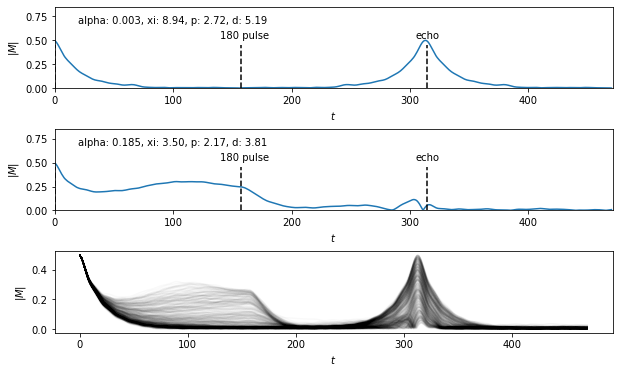

In [8]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(3,1, figsize=(10,6));

# change the following to see different curves
plot_idx1 = 0; # weak spin-spin coupling
plot_idx2 = 10; # strong spin-spin coupling

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, p: %.2f, d: %.2f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");

ax1[2].plot(abs(M[1:500,:]).T,color=(0,0,0,.025));
ax1[2].set(ylabel="$|M|$", xlabel="$t$");

fig1.subplots_adjust(hspace=.5)

In [11]:
# assemble the Re & Im parts of M at times 157, 314 into a dataframe
# along with the four material properties
var_dict = {'Re(157)':M_r[:,157],
            'Re(314)':M_r[:,314],
            'Im(157)':M_i[:,157],
            'Im(314)':M_i[:,314],
            'alpha':mat_info[:,0],
            'xi':mat_info[:,1],
            'p':mat_info[:,2],
            'd':mat_info[:,3]}
vars = pd.DataFrame(var_dict)
vars.head()

Re(157)   Re(314)   Im(157)   Im(314)     alpha         xi         p  \
0 -0.000069  0.000537  0.002359 -0.495251  0.002960   8.940169  2.717040   
1 -0.007806  0.001720 -0.004341 -0.234392  0.104608  19.497257  3.971238   
2  0.011923 -0.000039  0.003908 -0.415851  0.031753   0.939734  3.467178   
3 -0.011820  0.006070 -0.244514 -0.049414  0.189115   3.864133  3.013146   
4 -0.022681 -0.000907 -0.089024 -0.218253  0.130628   0.406269  2.520443   

          d  
0  5.189847  
1  4.585938  
2  3.542465  
3  3.864105  
4  3.544876

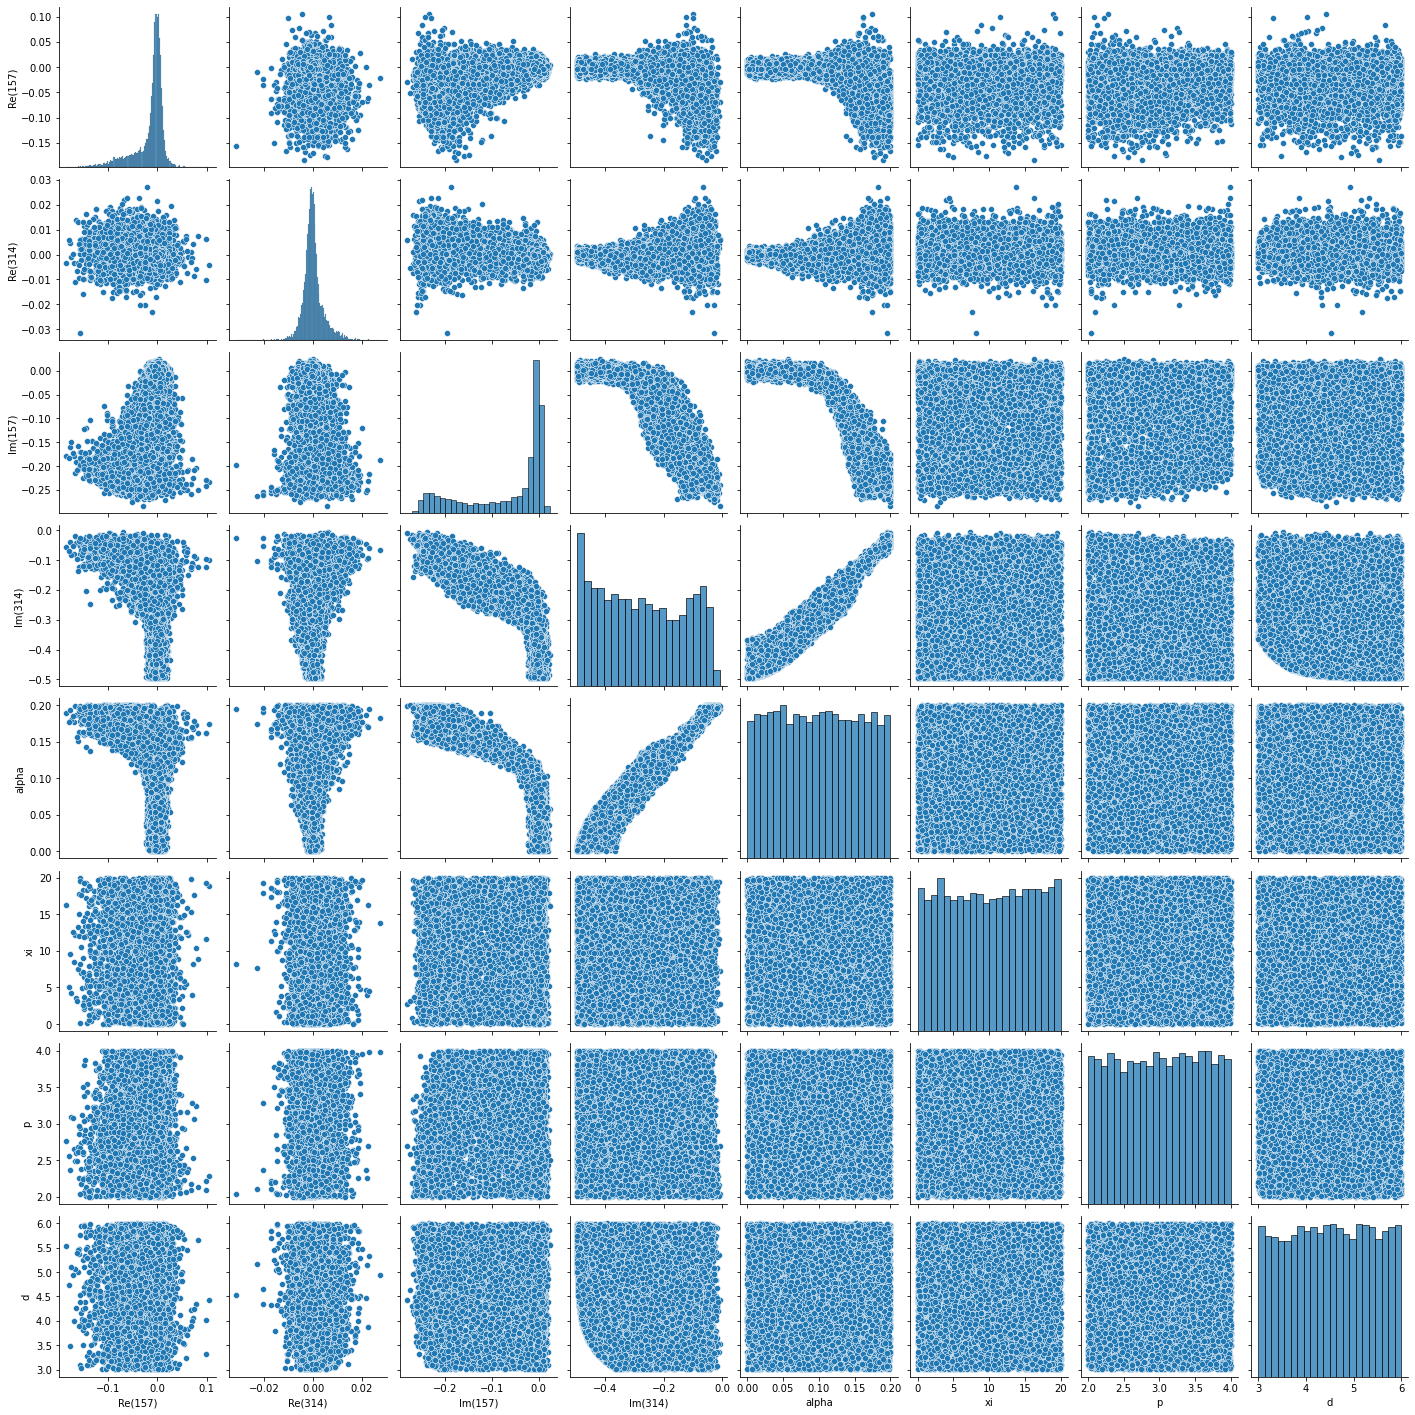

In [12]:
# use seaborn to plot each variable against the others
sns.pairplot(vars)

In [5]:
# partition data into a training and testing set using a random partition

# number of M(t) curves
N_data = np.shape(M)[0]

# pick a 90%/10% split for training/testing
test_frac = 0.10 # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data) # random ordering for all curves

train_idx = order_seed[0:div_idx] # first 90% of random order
test_idx = order_seed[div_idx:N_data] # last 10% of random order

# truncate time points to 210, 410
# !!! NOTE: May want to use all of the curve, takes longer to train though !!!
time_keep = range(210,410); # centered roughly at the echo

# concatenate the real and imaginary parts together, to make a real-vector of double the length
M_train = M[train_idx[:,None],time_keep]  # time truncation of input
mat_train = mat_info[train_idx,:]; # get the output
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part

# same as above, but for test
M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
M_test = np.hstack( (np.real(M_test), np.imag(M_test)) )

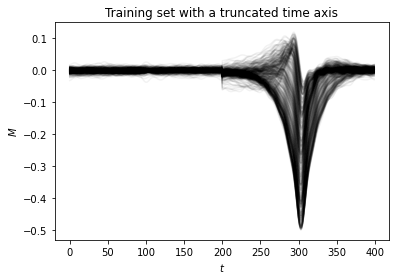

In [10]:
# plot the fist 500 elements of the training set, for visualizing variations in the data
plt.plot((M_train[1:500,:]).T,color=(0,0,0,.05));
plt.xlabel("$t$")
plt.ylabel("$M$")
plt.title("Training set with a truncated time axis");

In [22]:
M_train.shape

(9000, 400)

The quality of the model will be judged by the minimization of the error function:


$\textrm{Err} = \sum_{v=1}^{4} \sum_{i=i}^{500} \left( \frac{v^i_\textrm{model} - v^i_\textrm{true}}{w(v)} \right)^2 $

where $v^i$ is one of the four spin-interaction variables for echo number $i$, and $w_v$ normalizes the variation in each variable, according to:

$w(\alpha) = 0.2$

$w(\xi) = 20$

$w(p) = 2$

$w(d) = 3.$

In [6]:
import sklearn.metrics

In [7]:
# mean version of gross error metric above
def weight_mse(truth,predict,**kwargs):
    erf = 0.0
    weight = [0.2, 20, 2, 3]
    for col in range(4):
        erf += sklearn.metrics.mean_squared_error(truth[:,col],predict[:,col],**kwargs) / (weight[col]**2)
    return erf

## II. Autosklearn approach

In [8]:
import autosklearn.regression
from autosklearn.metrics import make_scorer

ModuleNotFoundError: No module named 'autosklearn'

In [8]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=6000,
    per_run_time_limit=600,
    max_models_on_disc=None,
    ensemble_memory_limit=2*1024,
    ml_memory_limit=4*1024,
    tmp_folder=None,
    output_folder='./autosklearn_out',
    delete_output_folder_after_terminate=False,
    n_jobs=2,
    metric=make_scorer('mean_squared_error',weight_mse)
)

In [10]:
automl.fit(M_train, mat_train)

[WARNING] [2020-10-29 16:19:51,851:AutoMLSMBO(1)::a08d58449c41dd34d8b552606f43586a] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/mean_squared_error_multioutput.regression_dense


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(dask_client=None,
                     delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=2048,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=25,
                     logging_config=None, max_models_on_disc=None,
                     metadata_directory=None, metric=None, ml_memory_limit=4096,
                     n_jobs=2, output_folder='./autosklearn_out',
                     per_run_time_limit=600, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     smac_scenario_args=None, time_left_for_this_task=6000,


In [19]:
print(automl.show_models())

[(1.000000, MyDummyRegressor(configuration=1, init_params=None, random_state=None)),
]


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [14]:
import pprint
pprint.pprint(automl.cv_results_)

{'budgets': [0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
             0.0,
          

       0.03264236]),
 'mean_test_score': array([0., 0., 0., ..., 0., 0., 0.]),
 'param_data_preprocessing:categorical_transformer:categorical_encoding:__choice__': masked_array(data=['no_encoding', 'one_hot_encoding', 'one_hot_encoding',
                   ..., 'one_hot_encoding', 'no_encoding', 'no_encoding'],
             mask=[False, False, False, ..., False, False, False],
       fill_value='N/A',
            dtype='<U16'),
 'param_data_preprocessing:categorical_transformer:category_coalescence:__choice__': masked_array(data=['minority_coalescer', 'minority_coalescer',
                   'minority_coalescer', ..., 'minority_coalescer',
                   'minority_coalescer', 'no_coalescense'],
             mask=[False, False, False, ..., False, False, False],
       fill_value='N/A',
            dtype='<U18'),
 'param_data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': masked_array(data=[0.0026150904111835473, 0.01, 0.0243319878372

 'params': [{'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.0026150904111835473,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize',
             'feature_preprocessor:__choice__': 'pca',
             'feature_preprocessor:pca:keep_variance': 0.5410109609735668,
             'feature_preprocessor:pca:whiten': 'True',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 2.317829114098478e-05,
             'regressor:gaussian_process:thetaL': 8.439771129997381e-07,
             'regressor:gaussian_process:thetaU': 464.7690685059453},
        

             'feature_preprocessor:random_trees_embedding:min_samples_leaf': 18,
             'feature_preprocessor:random_trees_embedding:min_samples_split': 13,
             'feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf': 1.0,
             'feature_preprocessor:random_trees_embedding:n_estimators': 91,
             'regressor:__choice__': 'k_nearest_neighbors',
             'regressor:k_nearest_neighbors:n_neighbors': 10,
             'regressor:k_nearest_neighbors:p': 2,
             'regressor:k_nearest_neighbors:weights': 'uniform'},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.036402368106509084,
             'data_preprocessing:numerical_transformer:imputation:str

             'feature_preprocessor:feature_agglomeration:pooling_func': 'median',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 4.703683900451197e-13,
             'regressor:gaussian_process:thetaL': 3.905635400623568e-08,
             'regressor:gaussian_process:thetaU': 16740.61717556613},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none',
             'feature_preprocessor:__choice__': 'no_preprocessing',
             'regressor:__choice__': 'extra_trees',
             'regressor:extra_trees:bootstrap': 'False',
             'regressor:extra_trees:criterion': 'mse',
             'regre

             'feature_preprocessor:polynomial:interaction_only': 'True',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 3.1531501024774862e-06,
             'regressor:gaussian_process:thetaL': 1.5046653349005763e-07,
             'regressor:gaussian_process:thetaU': 1.6690727631295124},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.11435465608430329,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.8726117446795

             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 18,
             'regressor:extra_trees:min_samples_split': 14,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.7059036974033526,
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.22633910425426304,
             'feature_preprocessor:__choice__': 'polynomial',
             'feature_preprocessor:polynomial:degree': 3,
             'fea

            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize',
             'feature_preprocessor:__choice__': 'no_preprocessing',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 0.0011533610166085324,
             'regressor:gaussian_process:thetaL': 5.891555065652239e-09,
             'regressor:gaussian_process:thetaU': 22.865692709983943},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numeri

             'feature_preprocessor:extra_trees_preproc_for_regression:bootstrap': 'False',
             'feature_preprocessor:extra_trees_preproc_for_regression:criterion': 'mae',
             'feature_preprocessor:extra_trees_preproc_for_regression:max_depth': 'None',
             'feature_preprocessor:extra_trees_preproc_for_regression:max_features': 0.6314190511705509,
             'feature_preprocessor:extra_trees_preproc_for_regression:max_leaf_nodes': 'None',
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_leaf': 20,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split': 7,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf': 0.0,
             'feature_preprocessor:extra_trees_preproc_for_regression:n_estimators': 100,
             'regressor:__choice__': 'decision_tree',
             'regressor:decision_tree:criterion': 'mse',
             'regressor:decision_tree:max

             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_leaf': 20,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split': 11,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf': 0.0,
             'feature_preprocessor:extra_trees_preproc_for_regression:n_estimators': 100,
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 1.8369827454101652e-11,
             'regressor:gaussian_process:thetaL': 3.854800008685869e-08,
             'regressor:gaussian_process:thetaU': 5874.438542208619},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerica

             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 6,
             'regressor:extra_trees:min_samples_split': 4,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize',
             'feature_preprocessor:__choice__': 'feature_agglomeration',
             'feature_preprocessor:feature_agglomeration:affinity': 'manhattan',
             'feature_preprocessor:feature_agglomeration:linkage': 'average',
             'feature_preprocessor:feature_agglomeration:n_clusters': 42,
             'feature_preprocessor:feature_agglo

             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none',
             'feature_preprocessor:__choice__': 'extra_trees_preproc_for_regression',
             'feature_preprocessor:extra_trees_preproc_for_regression:bootstrap': 'False',
             'feature_preprocessor:extra_trees_preproc_for_regression:criterion': 'friedman_mse',
             'feature_preprocessor:extra_trees_preproc_for_regression:max_depth': 'None',
             'feature_preprocessor:extra_trees_preproc_for_regression:max_features': 0.5128832941561507,
             'feature_preprocessor:extra_trees_preproc_for_regression:max_leaf_nodes': 'None',
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_leaf': 11,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split': 19,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf': 0.0,
             'feature_preprocessor:extra_trees_preproc_for_r

             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split': 12,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf': 0.0,
             'feature_preprocessor:extra_trees_preproc_for_regression:n_estimators': 100,
             'regressor:__choice__': 'extra_trees',
             'regressor:extra_trees:bootstrap': 'True',
             'regressor:extra_trees:criterion': 'friedman_mse',
             'regressor:extra_trees:max_depth': 'None',
             'regressor:extra_trees:max_features': 0.8210217940139863,
             'regressor:extra_trees:max_leaf_nodes': 'None',
             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 13,
             'regressor:extra_trees:min_samples_split': 20,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_e

             'regressor:decision_tree:max_leaf_nodes': 'None',
             'regressor:decision_tree:min_impurity_decrease': 0.0,
             'regressor:decision_tree:min_samples_leaf': 7,
             'regressor:decision_tree:min_samples_split': 19,
             'regressor:decision_tree:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.009497475080206715,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none',
             'feature_preprocessor:__choice__': 'fast_ica',
             'feature_preprocessor:fast_ica:algorithm': 'parallel',
             'featu

             'feature_preprocessor:random_trees_embedding:min_samples_split': 20,
             'feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf': 1.0,
             'feature_preprocessor:random_trees_embedding:n_estimators': 97,
             'regressor:__choice__': 'extra_trees',
             'regressor:extra_trees:bootstrap': 'True',
             'regressor:extra_trees:criterion': 'mse',
             'regressor:extra_trees:max_depth': 'None',
             'regressor:extra_trees:max_features': 0.48461840497563846,
             'regressor:extra_trees:max_leaf_nodes': 'None',
             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 19,
             'regressor:extra_trees:min_samples_split': 16,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categor

             'feature_preprocessor:__choice__': 'no_preprocessing',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 5.568873818814544e-07,
             'regressor:gaussian_process:thetaL': 5.715713102848579e-07,
             'regressor:gaussian_process:thetaU': 5453.504998895244},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00026815307030573067,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.7068933415774314,


             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax',
             'feature_preprocessor:__choice__': 'pca',
             'feature_preprocessor:pca:keep_variance': 0.8512353650537396,
             'feature_preprocessor:pca:whiten': 'True',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 0.0005771165117842408,
             'regressor:gaussian_process:thetaL': 3.5045244522764525e-05,
             'regressor:gaussian_process:thetaU': 10089.252783146963},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.07747341262912646,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
      

             'regressor:__choice__': 'random_forest',
             'regressor:random_forest:bootstrap': 'False',
             'regressor:random_forest:criterion': 'friedman_mse',
             'regressor:random_forest:max_depth': 'None',
             'regressor:random_forest:max_features': 0.7652129956098386,
             'regressor:random_forest:max_leaf_nodes': 'None',
             'regressor:random_forest:min_impurity_decrease': 0.0,
             'regressor:random_forest:min_samples_leaf': 6,
             'regressor:random_forest:min_samples_split': 6,
             'regressor:random_forest:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:resc

             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00017543125329281707,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax',
             'feature_preprocessor:__choice__': 'no_preprocessing',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 3.9082430748579675e-10,
             'regressor:gaussian_process:thetaL': 2.3970100469212588e-06,
             'regressor:gaussian_process:thetaU': 526.7637629673721},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00118637

             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize',
             'feature_preprocessor:__choice__': 'pca',
             'feature_preprocessor:pca:keep_variance': 0.6287791974230379,
             'feature_preprocessor:pca:whiten': 'True',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 1.7446943277731876e-11,
             'regressor:gaussian_process:thetaL': 3.1397637452217825e-06,
             'regressor:gaussian_process:thetaU': 25.792412930455896},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.09383175647790098,
   

             'regressor:random_forest:max_leaf_nodes': 'None',
             'regressor:random_forest:min_impurity_decrease': 0.0,
             'regressor:random_forest:min_samples_leaf': 2,
             'regressor:random_forest:min_samples_split': 18,
             'regressor:random_forest:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.06147628158563358,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax',
             'feature_preprocessor:__choice__': 'extra_trees_preproc_for_regression',
             'feature_preprocessor:extra_trees_preproc_for_r

             'regressor:extra_trees:max_leaf_nodes': 'None',
             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 18,
             'regressor:extra_trees:min_samples_split': 5,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.22000734849669387,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none',
             'feature_preprocessor:__choice__': 'feature_agglomeration',
             'feature_preprocessor:feature_agglomeration:affinity': 'cosine',
  

            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00011903127597832558,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer',
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 998,
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:output_distribution': 'normal',
             'feature_preprocessor:__choice__': 'pca',
             'feature_preprocessor:pca:keep_variance': 0.84819059488093,
             'feature_preprocessor:pca:whiten': 'True',
             'regressor:__choice__': 'random_fo

             'feature_preprocessor:extra_trees_preproc_for_regression:max_depth': 'None',
             'feature_preprocessor:extra_trees_preproc_for_regression:max_features': 0.770021162102619,
             'feature_preprocessor:extra_trees_preproc_for_regression:max_leaf_nodes': 'None',
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_leaf': 15,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_samples_split': 9,
             'feature_preprocessor:extra_trees_preproc_for_regression:min_weight_fraction_leaf': 0.0,
             'feature_preprocessor:extra_trees_preproc_for_regression:n_estimators': 100,
             'regressor:__choice__': 'extra_trees',
             'regressor:extra_trees:bootstrap': 'True',
             'regressor:extra_trees:criterion': 'mse',
             'regressor:extra_trees:max_depth': 'None',
             'regressor:extra_trees:max_features': 0.7041526151779454,
             'regressor:extra_trees:max_lea

             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 1.3094903762446713e-05,
             'regressor:gaussian_process:thetaL': 1.4025806411423046e-06,
             'regressor:gaussian_process:thetaU': 160.944146004964},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.0002709462277198004,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize',
             'feature_preprocessor:__choice__': 'random_trees_embedding',
             'feature_preprocessor:random_trees_embedding:bootstrap': 'True',
             'feature_preprocessor

             'regressor:__choice__': 'random_forest',
             'regressor:random_forest:bootstrap': 'False',
             'regressor:random_forest:criterion': 'friedman_mse',
             'regressor:random_forest:max_depth': 'None',
             'regressor:random_forest:max_features': 0.7098818151983499,
             'regressor:random_forest:max_leaf_nodes': 'None',
             'regressor:random_forest:min_impurity_decrease': 0.0,
             'regressor:random_forest:min_samples_leaf': 14,
             'regressor:random_forest:min_samples_split': 2,
             'regressor:random_forest:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.0717524895177552,
            

             'feature_preprocessor:pca:keep_variance': 0.8997117475665115,
             'feature_preprocessor:pca:whiten': 'False',
             'regressor:__choice__': 'random_forest',
             'regressor:random_forest:bootstrap': 'False',
             'regressor:random_forest:criterion': 'mse',
             'regressor:random_forest:max_depth': 'None',
             'regressor:random_forest:max_features': 0.7483158200586928,
             'regressor:random_forest:max_leaf_nodes': 'None',
             'regressor:random_forest:min_impurity_decrease': 0.0,
             'regressor:random_forest:min_samples_leaf': 17,
             'regressor:random_forest:min_samples_split': 15,
             'regressor:random_forest:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_prepr

             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer',
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 1701,
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:output_distribution': 'uniform',
             'feature_preprocessor:__choice__': 'pca',
             'feature_preprocessor:pca:keep_variance': 0.8640523443987127,
             'feature_preprocessor:pca:whiten': 'True',
             'regressor:__choice__': 'random_forest',
             'regressor:random_forest:bootstrap': 'True',
             'regressor:random_forest:criterion': 'mse',
             'regressor:random_forest:max_depth': 'None',
             'regressor:random_forest:max_features': 0.90889590515

             'feature_preprocessor:fast_ica:fun': 'logcosh',
             'feature_preprocessor:fast_ica:whiten': 'False',
             'regressor:__choice__': 'random_forest',
             'regressor:random_forest:bootstrap': 'True',
             'regressor:random_forest:criterion': 'mae',
             'regressor:random_forest:max_depth': 'None',
             'regressor:random_forest:max_features': 0.7060933141344603,
             'regressor:random_forest:max_leaf_nodes': 'None',
             'regressor:random_forest:min_impurity_decrease': 0.0,
             'regressor:random_forest:min_samples_leaf': 16,
             'regressor:random_forest:min_samples_split': 3,
             'regressor:random_forest:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numeri

             'feature_preprocessor:fast_ica:whiten': 'False',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 0.2173714585199658,
             'regressor:gaussian_process:thetaL': 5.230479568144596e-09,
             'regressor:gaussian_process:thetaU': 58826.43159374155},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.8069850825909785,
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.24370557194954917,
             'feature_preprocessor:__choice__

             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.00010413402132113047,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize',
             'feature_preprocessor:__choice__': 'polynomial',
             'feature_preprocessor:polynomial:degree': 3,
             'feature_preprocessor:polynomial:include_bias': 'True',
             'feature_preprocessor:polynomial:interaction_only': 'False',
             'regressor:__choice__': 'k_nearest_neighbors',
             'regressor:k_nearest_neighbors:n_neighbors':

             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer',
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 1284,
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:output_distribution': 'normal',
             'feature_preprocessor:__choice__': 'feature_agglomeration',
             'feature_preprocessor:feature_agglomeration:affinity': 'manhattan',
             'feature_preprocessor:feature_agglomeration:linkage': 'complete',
             'feature_preprocessor:feature_agglomeration:n_clusters': 323,
             'feature_preprocessor:feature_agglomeration:pooling_func': 'median',
             'regressor:__choice__': 'random_forest',
             'regressor:random_forest:bootstrap': 'True',
             'regressor:random_forest:criterion': 'mae',
             'regressor:random

             'regressor:random_forest:bootstrap': 'True',
             'regressor:random_forest:criterion': 'mse',
             'regressor:random_forest:max_depth': 'None',
             'regressor:random_forest:max_features': 0.3975892793800563,
             'regressor:random_forest:max_leaf_nodes': 'None',
             'regressor:random_forest:min_impurity_decrease': 0.0,
             'regressor:random_forest:min_samples_leaf': 20,
             'regressor:random_forest:min_samples_split': 17,
             'regressor:random_forest:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.03021805776028274,
             'data_preprocessing:numerical_transformer:imputation:str

             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none',
             'feature_preprocessor:__choice__': 'random_trees_embedding',
             'feature_preprocessor:random_trees_embedding:bootstrap': 'True',
             'feature_preprocessor:random_trees_embedding:max_depth': 2,
             'feature_preprocessor:random_trees_embedding:max_leaf_nodes': 'None',
             'feature_preprocessor:random_trees_embedding:min_samples_leaf': 9,
             'feature_preprocessor:random_trees_embedding:min_samples_split': 17,
             'feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf': 1.0,
             'feature_preprocessor:random_trees_embedding:n_estimators': 89,
             'regressor:__choice__': 'k_nearest_neighbors',
             'regressor:k_nearest_neighbors:n_neighbors': 7,
             'regressor:k_nearest_neighbors:p': 2,
           

             'feature_preprocessor:__choice__': 'feature_agglomeration',
             'feature_preprocessor:feature_agglomeration:affinity': 'euclidean',
             'feature_preprocessor:feature_agglomeration:linkage': 'ward',
             'feature_preprocessor:feature_agglomeration:n_clusters': 18,
             'feature_preprocessor:feature_agglomeration:pooling_func': 'mean',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 1.2453288014310827e-12,
             'regressor:gaussian_process:thetaL': 4.5464768201085507e-07,
             'regressor:gaussian_process:thetaU': 10794.649753303738},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.

             'regressor:decision_tree:max_features': 1.0,
             'regressor:decision_tree:max_leaf_nodes': 'None',
             'regressor:decision_tree:min_impurity_decrease': 0.0,
             'regressor:decision_tree:min_samples_leaf': 5,
             'regressor:decision_tree:min_samples_split': 13,
             'regressor:decision_tree:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.07046559246634433,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize',
             'feature_preprocessor:__choice__': 'feature_agglomeration',
     

             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 12,
             'regressor:extra_trees:min_samples_split': 6,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'quantile_transformer',
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 771,
             'data_preprocessing:numerical_transformer:rescaling:quantile_transformer:output_distribution': 'uniform',
             'feature_preprocessor:__choice__': 'pca',
             'feature_preprocessor:pca:keep_variance'

             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.18619722902868574,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.8281367071966669,
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.02801360635065187,
             'feature_preprocessor:__choice__': 'random_trees_embedding',
             'feature_preprocessor:random_trees_embedding:bootstrap': 'False',
             'feature_preprocessor:random_trees_embedding:max_depth': 4,
             'feature_preprocessor:random_trees_embedding:max_leaf_nodes': 'None',
             'feature_preprocessor:random_trees_embedding:min_samples_leaf': 16,
             'feature_preprocessor:random_trees_embedding:min_samples

             'regressor:gaussian_process:alpha': 3.265184248309315e-08,
             'regressor:gaussian_process:thetaL': 0.0003684281918092574,
             'regressor:gaussian_process:thetaU': 1.9949160328227793},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.003496197482982142,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.813232219472811,
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.04047828518841072,
             'featu

             'feature_preprocessor:pca:keep_variance': 0.5664137082229997,
             'feature_preprocessor:pca:whiten': 'True',
             'regressor:__choice__': 'gaussian_process',
             'regressor:gaussian_process:alpha': 0.5428220630761922,
             'regressor:gaussian_process:thetaL': 1.961470784088666e-09,
             'regressor:gaussian_process:thetaU': 3439.7481423582985},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'median',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize',
             'feature_preprocessor:__choice__': 'random_trees_embedding',
             'feature_preprocessor:random_trees_embedding:bootstrap': 'True',
             'feature_preprocessor:random_trees_e

             'regressor:decision_tree:min_impurity_decrease': 0.0,
             'regressor:decision_tree:min_samples_leaf': 1,
             'regressor:decision_tree:min_samples_split': 2,
             'regressor:decision_tree:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer',
             'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.07616670960586398,
             'data_preprocessing:numerical_transformer:imputation:strategy': 'mean',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler',
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.804213247607784,
             'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_min': 0.1332846945

             'regressor:__choice__': 'extra_trees',
             'regressor:extra_trees:bootstrap': 'True',
             'regressor:extra_trees:criterion': 'mae',
             'regressor:extra_trees:max_depth': 'None',
             'regressor:extra_trees:max_features': 0.9689775994443939,
             'regressor:extra_trees:max_leaf_nodes': 'None',
             'regressor:extra_trees:min_impurity_decrease': 0.0,
             'regressor:extra_trees:min_samples_leaf': 9,
             'regressor:extra_trees:min_samples_split': 12,
             'regressor:extra_trees:min_weight_fraction_leaf': 0.0},
            {'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',
             'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
             'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent',
             'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robu

            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            'Crash',
            '

That output could not be less helpful. I've spent too much time on this.

In [15]:
predictions = automl.predict(M_test)

In [18]:
print("Competition score:", weight_mse(mat_test, predictions))

Competition score: 0.3423463291374544


In [9]:
import pickle

In [17]:
with open('autosklearn-results.pkl','wb') as cellar:
    pickle.dump([predictions,mat_test],cellar)

In [20]:
with open('autosklearn-output.pkl','wb') as cellar:
    pickle.dump(automl.cv_results_,cellar)

In [10]:
with open('autosklearn-results.pkl','rb') as cellar:
    [predictions,mat_test] = pickle.load(cellar)

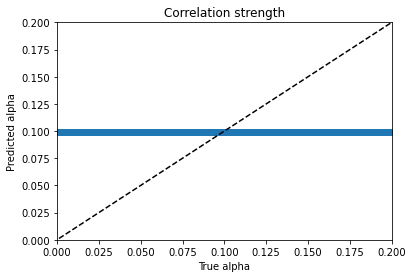

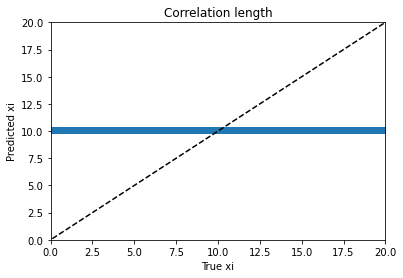

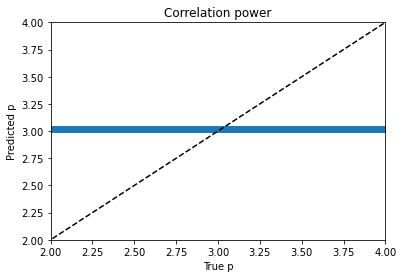

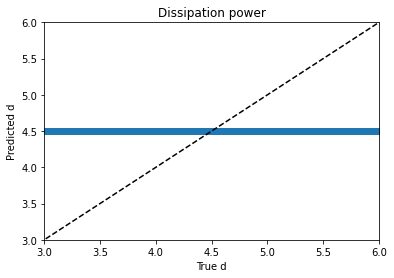

In [11]:
plt.scatter(mat_test[:,0],predictions[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],predictions[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],predictions[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],predictions[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

### Verdict
Autosklearn: 0-1.

## II. Reconstruct KNN regression without autosklearn

data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding',

'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 

'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.009456687905885589, 

'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 

'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 

'feature_preprocessor:__choice__': 'random_trees_embedding', 

'feature_preprocessor:random_trees_embedding:bootstrap': 'False', 

'feature_preprocessor:random_trees_embedding:max_depth': 6, 

'feature_preprocessor:random_trees_embedding:max_leaf_nodes': 'None', 

'feature_preprocessor:random_trees_embedding:min_samples_leaf': 19, 

'feature_preprocessor:random_trees_embedding:min_samples_split': 13, 

'feature_preprocessor:random_trees_embedding:min_weight_fraction_leaf': 1.0, 

'feature_preprocessor:random_trees_embedding:n_estimators': 14, 

'regressor:__choice__': 'k_nearest_neighbors', 

'regressor:k_nearest_neighbors:n_neighbors': 1, 

'regressor:k_nearest_neighbors:p': 2, 

'regressor:k_nearest_neighbors:weights': 'uniform'},

dataset_properties={
  'task': 5,
  'sparse': False,
  'multioutput': True,
  'target_type': 'regression',
  'signed': False})),

In [12]:
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neighbors import KNeighborsRegressor

In [13]:
normer = Normalizer()
embedder = RandomTreesEmbedding(max_depth=6,max_leaf_nodes=None,
                               min_samples_leaf=19,min_samples_split=13,n_estimators=14)
knrmodel = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1, weights='uniform', p=2)

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
luigi = Pipeline([('norm',normer),('rte',embedder),('knnr',knrmodel)])

In [16]:
luigi.fit(M_train,mat_train)
knr_pred = luigi.predict(M_test)
weight_mse(mat_test,knr_pred)

0.6997666276757397

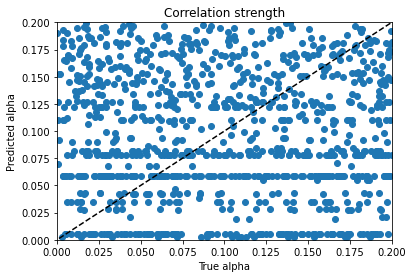

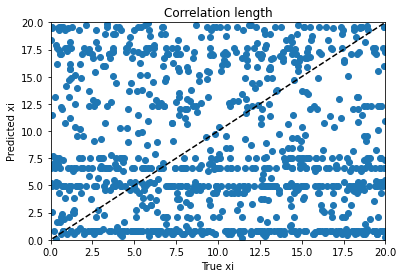

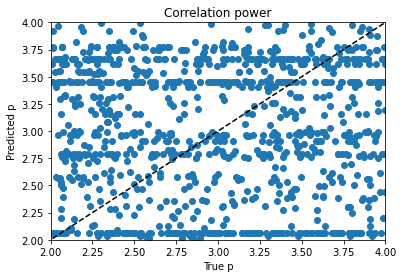

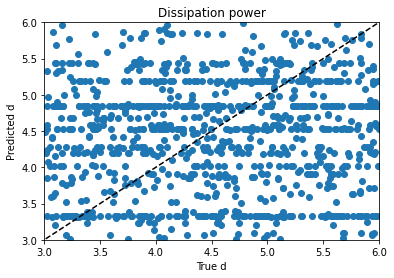

In [23]:
plt.scatter(mat_test[:,0],knr_pred[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],knr_pred[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],knr_pred[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],knr_pred[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

### Question
In that pipeline, were the preprocessing steps fit to just features or features and targets? Implicitly, from the User Guide on pipelines, I say just features. There is a `TransformedTargetRegressor` wrapper to transform targets, fit, predict, then inverse transform for results.

## III. A New Day
First of all, we'll scale the targets by their weights in the final error metric.

Wait. I can just apply MinMaxScaler, right? 0-1, easy, can unscale.

Then we'll briefly check out this autosklearn v.2. Wait. There is the barest hint of documentation of a classifier and no suggestion of a regressor. Well, then. Back to v.1 and see if I can print a list of models autosklearn has tried, and if not, back to the salt mine and pull some manually.

In [25]:
# Pipeline = (SelectPercentile(mutual_info),
#             boxcox,
#             RegressorChain(TransformTargets(Regressors, StandardScaler)))
# Regressors = [SGD, PLS, RandomForest, ExtraTrees]

In [18]:
from sklearn.compose import TransformedTargetRegressor

In [29]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import SGDRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [33]:
def mutual_info_total(X,y):
    """sums the mutual info score across multiple targets"""
    scores=np.zeros(X.shape[1])
    for i in range(y.shape[1]):
        scores+=mutual_info_regression(X,y[:,i])
    return scores

In [35]:
selector = SelectPercentile(mutual_info_total,percentile=50)
scaler = MinMaxScaler()

In [37]:
# I SO wanted to write mtmte for More Than Meets The Eye because, you know, Transformers
# but I was thinking of you, O code reader.
transform = PowerTransformer()

In [28]:
regressors = [SGDRegressor(loss='epsilon_insensitive',penalty='l1',random_state=84,learning_rate='adaptive',
                          early_stopping=True),
              PLSRegression(n_components=4),
              RandomForestRegressor(n_jobs=2,random_state=84,max_samples=0.35),
              ExtraTreesRegressor(n_jobs=2,random_state=84,max_samples=0.35)]

In [38]:
mario = []
# order of decreasing visible target information in the pairplot above
col_order = [0,3,2,1]
for i in range(4):
    mario.append(Pipeline([('cut',selector),('trans',transform),('estimator',
                           RegressorChain(TransformedTargetRegressor(
                           regressor=regressors[i],transformer=scaler),
                           order=col_order,random_state=84))],memory='regressor-trove'))
    mario[i].fit(M_train,mat_train)
    print('Training score for model ',i,weight_mse(mat_train,mario[i].predict(M_train)))
    print('Test score for model ',i,weight_mse(mat_test,mario[i].predict(M_test)))

Training score for model  0 0.18407899223384525
Test score for model  0 0.502828388646591
Training score for model  1 0.23498232238334102
Test score for model  1 0.44699413983241837
Training score for model  2 0.08370574942124111
Test score for model  2 0.5150849468579746
Training score for model  3 2.519518354330262e-25
Test score for model  3 0.5381939737467831


SGD - linear support vector model


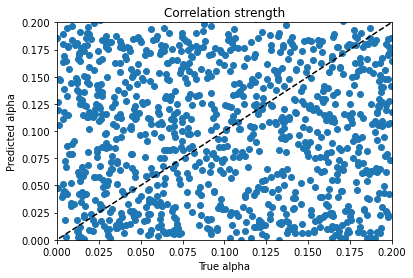

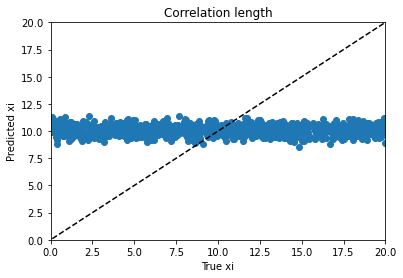

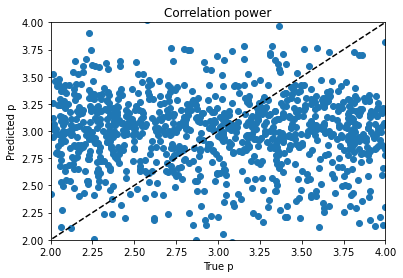

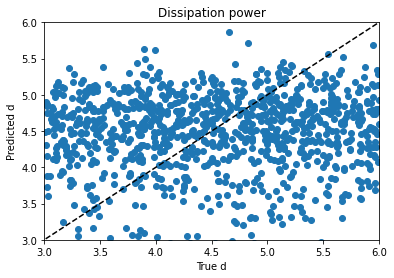

In [39]:
print("SGD - linear support vector model")

plt.scatter(mat_test[:,0],mario[0].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mario[0].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mario[0].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mario[0].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Partial Least Squares


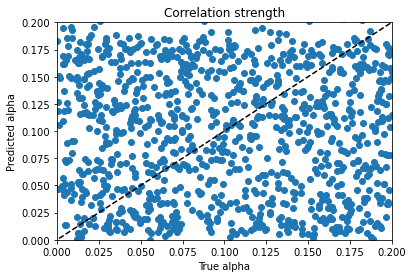

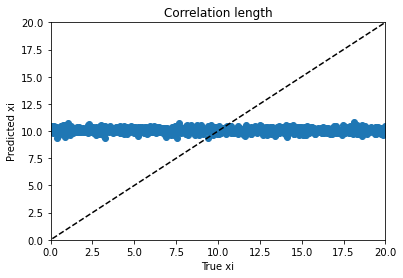

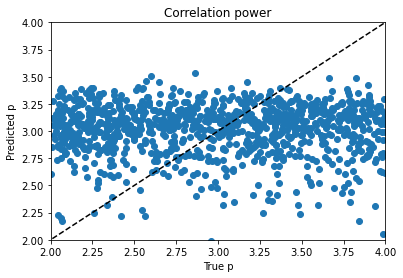

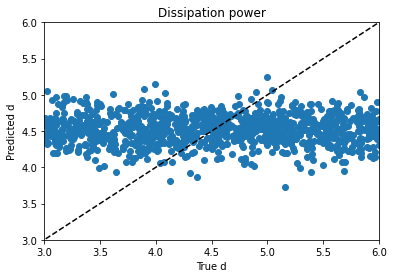

In [40]:
print("Partial Least Squares")

plt.scatter(mat_test[:,0],mario[1].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mario[1].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mario[1].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mario[1].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Random Forest


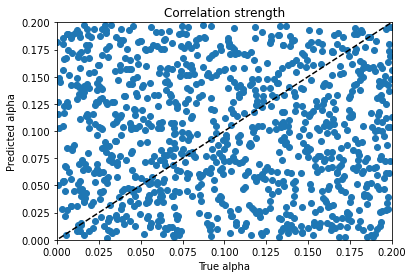

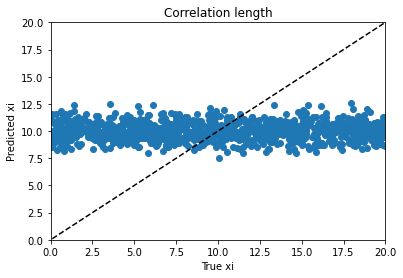

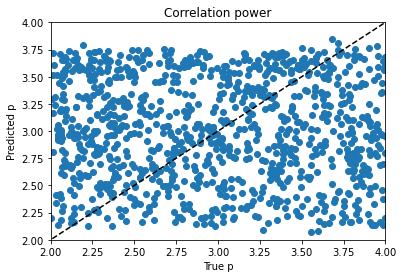

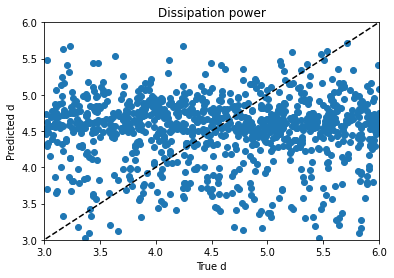

In [41]:
print("Random Forest")

plt.scatter(mat_test[:,0],mario[2].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mario[2].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mario[2].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mario[2].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Extra Trees


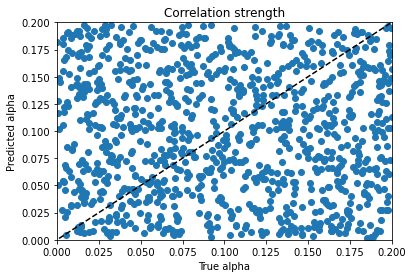

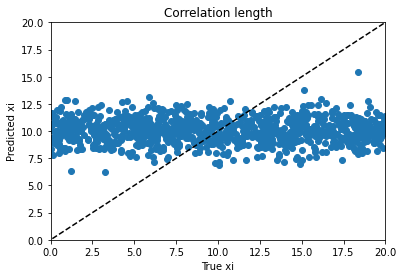

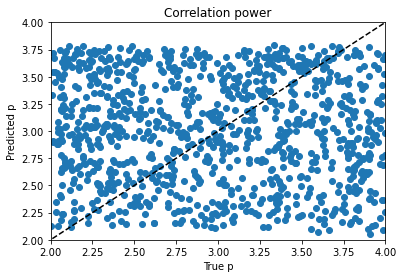

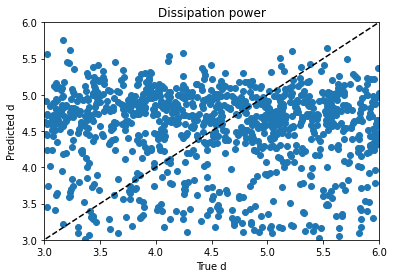

In [42]:
print("Extra Trees")

plt.scatter(mat_test[:,0],mario[3].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mario[3].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mario[3].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mario[3].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

In [46]:
peach = []
# order of decreasing visible target information in the pairplot above
col_order = [0,3,2,1]
for i in range(4):
    peach.append(RegressorChain(regressors[i],order=col_order,random_state=84))
    peach[i].fit(M_train,mat_train)
    try:
        print('Training score for model ',i,weight_mse(mat_train,peach[i].predict(M_train)))
        print('Test score for model ',i,weight_mse(mat_test,peach[i].predict(M_test)))
    except:
        pass

Training score for model  0 0.30459156354487316
Test score for model  0 0.36735424002887884
Training score for model  2 0.08491371385485089
Test score for model  2 0.5064646318467432
Training score for model  3 1.4402216699960564e-23
Test score for model  3 0.5272426297014053


SGD - linear support vector model


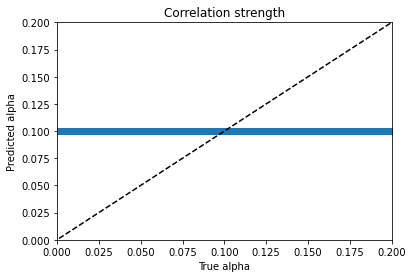

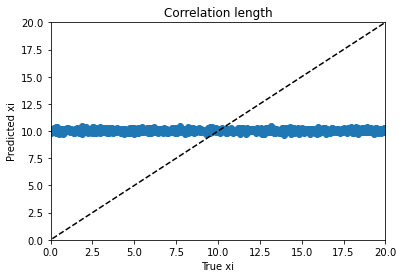

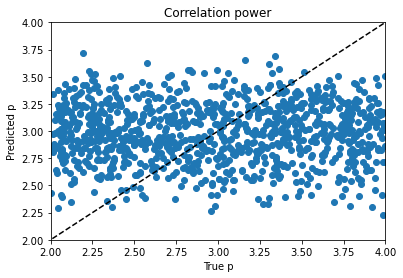

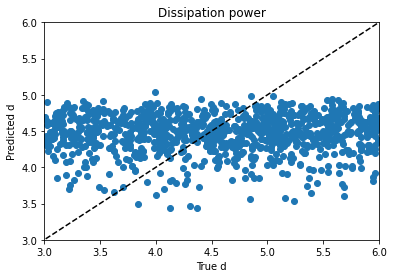

In [47]:
print("SGD - linear support vector model")

plt.scatter(mat_test[:,0],peach[0].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],peach[0].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],peach[0].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],peach[0].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

In [50]:
print("Partial Least Squares")

plt.scatter(mat_test[:,0],peach[1].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],peach[1].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],peach[1].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],peach[1].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Partial Least Squares


ValueError: could not broadcast input array from shape (1000,1) into shape (1000)

Random Forest


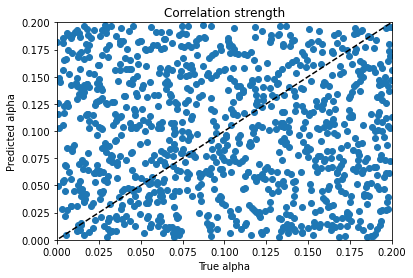

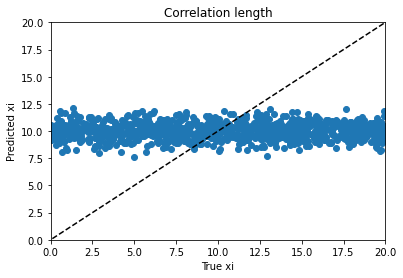

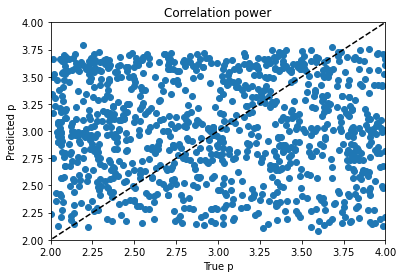

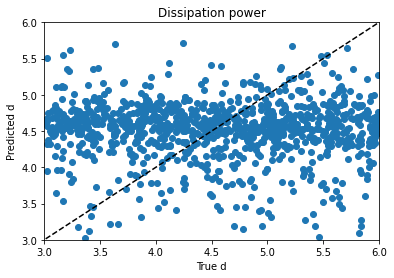

In [48]:
print("Random Forest")

plt.scatter(mat_test[:,0],peach[2].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],peach[2].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],peach[2].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],peach[2].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Extra Trees


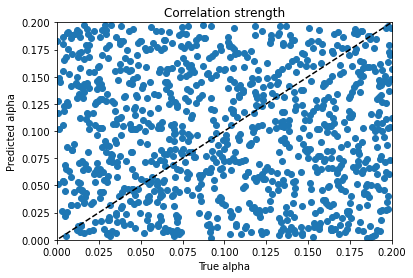

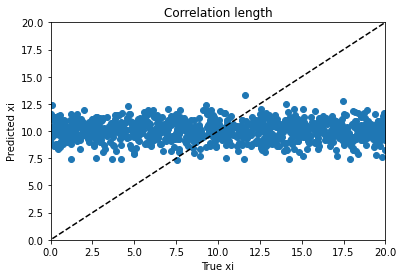

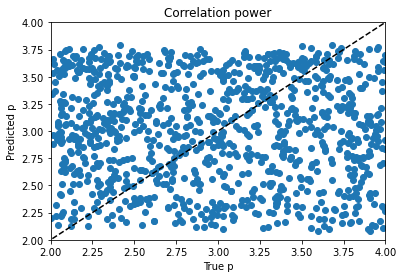

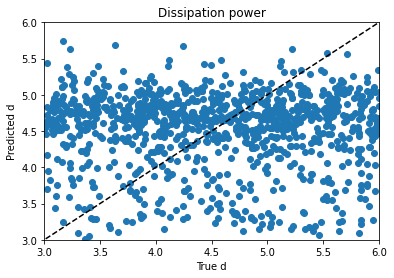

In [49]:
print("Extra Trees")

plt.scatter(mat_test[:,0],peach[3].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],peach[3].predict(M_test)[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],peach[3].predict(M_test)[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],peach[3].predict(M_test)[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

In [ ]:
# find and plot mutual info scores for all features and each target variable
mralpha = mutual_info_regression()
mialpha = 

In [ ]:
plt.scatter(mat_test[:,0],peach[3].predict(M_test)[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")